# First Steps with TensorFlow
### Learning Objectives:
* Learn fundamental TensorFlow concepts
* Use the LinearRegressor class in TensorFlow to predict median housing price, at the granularity of city blocks, based on one input feature
* Evaluate teh accouracy of a model's predictions using Root Mean Squared Error (RMSE)
* Improve the accuracy of a model by tuning its hyperparameters

# Setup phase

In [3]:
import math
from IPython import display
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Load our data set.

In [12]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

Randomize the data, just to be sure not to get pathological ordering effects that might harm the performance of Stochastic Gradient Descent.

In [13]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

Scale `median_house_value` to be in units of thousands

In [14]:
california_housing_dataframe['median_house_value'] = california_housing_dataframe['median_house_value']/1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8369,-118.5,34.0,37.0,388.0,83.0,248.0,84.0,5.2,326.7
3681,-117.9,33.7,14.0,6224.0,1679.0,3148.0,1589.0,4.2,430.9
8662,-118.5,34.2,25.0,4409.0,1018.0,4579.0,1010.0,2.9,245.1
4464,-118.0,34.1,39.0,2522.0,380.0,1113.0,357.0,5.2,445.2
6884,-118.3,33.8,25.0,2659.0,765.0,2629.0,726.0,2.6,175.9
...,...,...,...,...,...,...,...,...,...
16320,-122.5,37.8,45.0,1620.0,344.0,941.0,328.0,4.4,270.2
4010,-118.0,34.1,31.0,2516.0,526.0,2194.0,497.0,3.2,155.5
10336,-120.1,39.2,20.0,1703.0,294.0,409.0,174.0,3.1,196.9
14784,-122.2,37.5,41.0,733.0,155.0,652.0,140.0,5.2,233.6


# Examine the Data
it's a good idea to get to know your data a little bit before you work with it.

In [15]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


# Build the First Model
In this exercise, we'll try to predict `median_house_value`, which will be our label (sometimes also called a target). We'll use `total_rooms` as our input feature.
To train model, we'll use the [LinearRegresor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/premade_estimators) API.
In TensorFlow, we indicate a feature's data type using a construct called a __feature column__
***
### Step1: Define Features and Configure Feature Columns
To start, we're going to use just one numeric input feature, `total_rooms`. 

In [22]:
# Define the input feature: total_rooms.
# [[]] = DataFrame data type 
# [] = Series data type
my_feature = california_housing_dataframe[['total_rooms']]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column('total_rooms')]
feature_columns

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Step2: Define the Target
Next, we'll define our target, which is `median_house_value`. Again, we can pull it from our `california_housing_dataframe`

In [23]:
# Define the label.
targets = california_housing_dataframe['median_house_value']

### Step3: Configure the LinearRegressor
We'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent(SGD). The `learning_rate` argument controls the size of the gradient step.


__NOTE:__ To be safe, we also apply [Gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail.

In [25]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=10**-7)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)

### Step4: Define the Input Function
To import our California housing data into our LinearRegressor, we need to define an input function, which instructs TensorFlow how to preprecess the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our `pandas` feature data into a dict of Numpy arrays. We can then use the TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) to construct a dataset object from our data, and then break our data into batches of `batch_size`, to be repeated for the specified number of epochs (`num_epochs`)

__NOTE:__ When the default value of `num_epochs=None` is passed to repeat()

Next, if `suffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifieds the size of the dataset from which `shuffle` will randomly sample.

In [26]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
    
    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Whether to shuffle the data
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
        Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()} #Dict comprehension
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size = 10**4)
        
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Step5: Train the Model
We can now call `train()` on our `linear_regressor` to train the model. We'll warp `my_input_fn` in a `lambda` so we can pass in `my_feature` and `target` as arguments (see this [TensorFlow input function tutorial](https://www.tensorflow.org/get_started/datasets_quickstart#passing_input_fn_data_to_your_model) for more details), and to start, we'll train for 100 steps.

In [28]:
# Call function with no argument by lambda function
_ = linear_regressor.train(input_fn= lambda:my_input_fn(my_feature, targets), steps=100) 

### Step6: Evaluate the Model
Let's make predictions on that training data, to see how well our model fit it during training.

In [30]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error. 
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print('Mean Squared Error (on training data): %0.3f' % mean_squared_error)
print('Root Mean Squared Error (on training data): %0.3f' % root_mean_squared_error)

Mean Squared Error (on training data): 56308.998
Root Mean Squared Error (on training data): 237.295


Let's compare the RMSE to the difference of the min and max of our targets:

In [31]:
min_house_value = california_housing_dataframe['median_house_value'].min()
max_house_value = california_housing_dataframe['median_house_value'].max()
min_max_difference = max_house_value - min_house_value

print('Min. Median House Value: %0.3f' % min_house_value)
print('Max. Median House Value: %0.3f' % max_house_value)
print('Difference between Min. and Max.: %0.3f' % min_max_difference)
print('Root Mean Squared Error: %0.3f' % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.295


Our error spans nearly half teh range of teh target values. Can we do better?

This is the question that nags at every model developer.Let's develop some basic strategies to reduce model error.

In [33]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()


,predictions,targets
count,17000.0,17000.0
mean,0.3,207.3
std,0.2,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.2,180.4
75%,0.3,265.0
max,3.8,500.0


We can also visualize the data and the line we've learned. Recall that linear regression on a single feature can be drawn as a line mapping input x to output y.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [35]:
sample = california_housing_dataframe.sample(n=300)
sample

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15728,-122.4,37.8,32.0,352.0,132.0,313.0,105.0,2.6,350.0
13385,-121.9,38.4,15.0,1263.0,211.0,665.0,208.0,4.5,260.9
7987,-118.4,34.0,37.0,1629.0,275.0,668.0,266.0,6.1,387.2
1244,-117.1,32.9,7.0,1308.0,418.0,766.0,390.0,3.2,106.3
7045,-118.3,34.2,37.0,589.0,119.0,375.0,122.0,3.4,222.7
...,...,...,...,...,...,...,...,...,...
8835,-118.7,34.3,27.0,727.0,136.0,467.0,144.0,3.7,250.0
12213,-121.5,39.5,19.0,3720.0,636.0,1304.0,607.0,2.7,97.5
10908,-120.8,37.8,15.0,3553.0,659.0,1684.0,611.0,3.3,131.2
1707,-117.2,34.2,35.0,2707.0,481.0,1595.0,479.0,3.9,91.5


Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot.

The line will show up red.

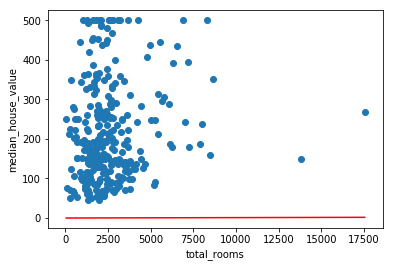

In [37]:
# Get the min and max total_rooms values.
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plot our regressiono line from (x_0, y_0) to (x_1, y_1)
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

# Plot a scatter plot from our data sample.
plt.scatter(sample['total_rooms'], sample['median_house_value'])

# Display graph
plt.show()
